### Laboratory work 9 - Development of tracking filter of a moving object when measurements and motion model are in different coordinate systems
#### Abramov Semen, Belikov Ilia, Nikolay Zherdev, Mikhail Kulbeda
#### Skoltech, 17.10.2018

The objective of this laboratory work is to develop a tracking filter of a moving object when measurements and motion model are in different coordinate systems. This problem is typical for radio navigation systems. Important outcome of this exercise is to detect main difficulties of practical Kalman filter implementation related with instability zone of a tracking filter, and to analyze conditions under which navigation system may become blind and filter diverges. This is important to prevent collisions and for other safety issues.

In [76]:
import pandas as pd
import numpy as np
from math import pi
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from tqdm import tqdm_notebook as tqdm

from numpy import linalg as LA

init_notebook_mode(connected=True)

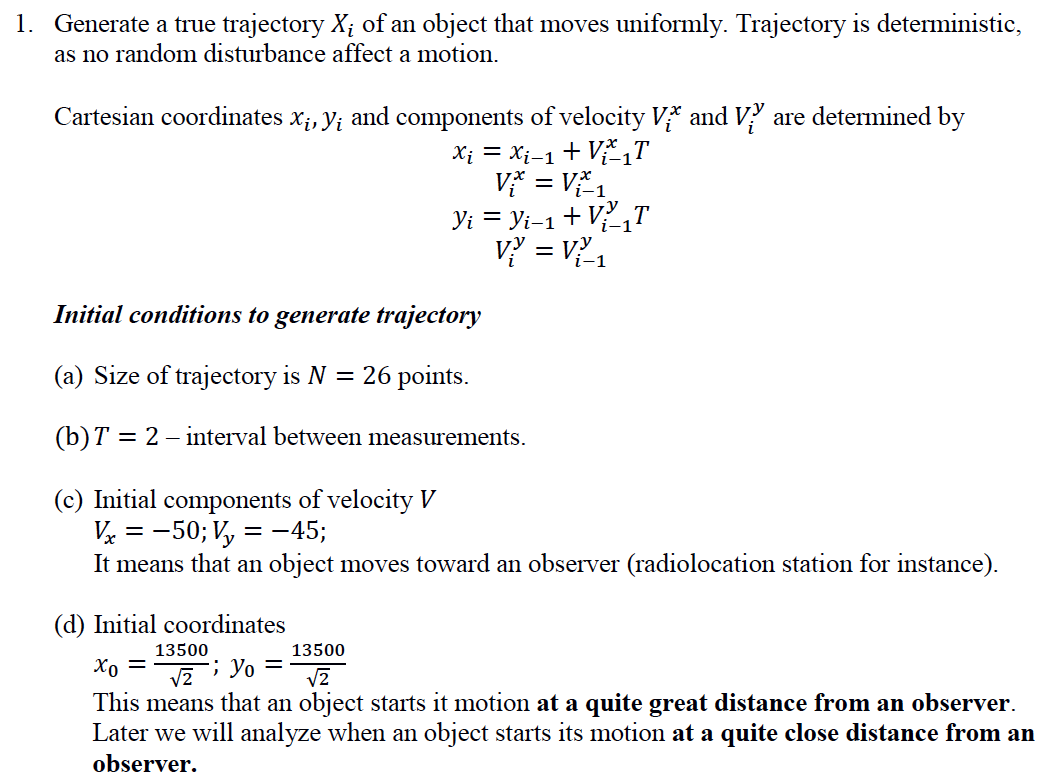

In [77]:
def generate_trajectory(x0 = 13500/np.sqrt(2), y0 = 13500/np.sqrt(2), vx0 = -50, vy0 = -45, T = 2, N = 26):
    
    Vx = np.full((N), vx0)
    Vy = np.full((N), vy0)
    X = np.zeros((N))
    Y = np.zeros((N))
    
    Y[0] = y0
    X[0] = x0
    X[1:] += Vx[:-1]*T
    Y[1:] += Vy[:-1]*T
    
    return np.array([np.cumsum(X), Vx, np.cumsum(Y), Vy])
    

In [78]:
X, Vx, Y, Vy = generate_trajectory(x0 = 13500/np.sqrt(2), y0 = 13500/np.sqrt(2), vx0 = -50, vy0 = -45, T = 2, N = 26)

In [79]:
# tr = generate_trajectory(x0 = 13500/np.sqrt(2), y0 = 13500/np.sqrt(2), vx0 = -50, vy0 = -45, T = 2, N = 26)

In [80]:
data = [
    go.Scatter(
        x = X,
        y = Y,
        name='trajectory'
    ),
#     go.Scatter(
#         y=velocity,
#         name='velocity'
#     ),
]

layout= go.Layout(
    title= 'Cartesian coordinates',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

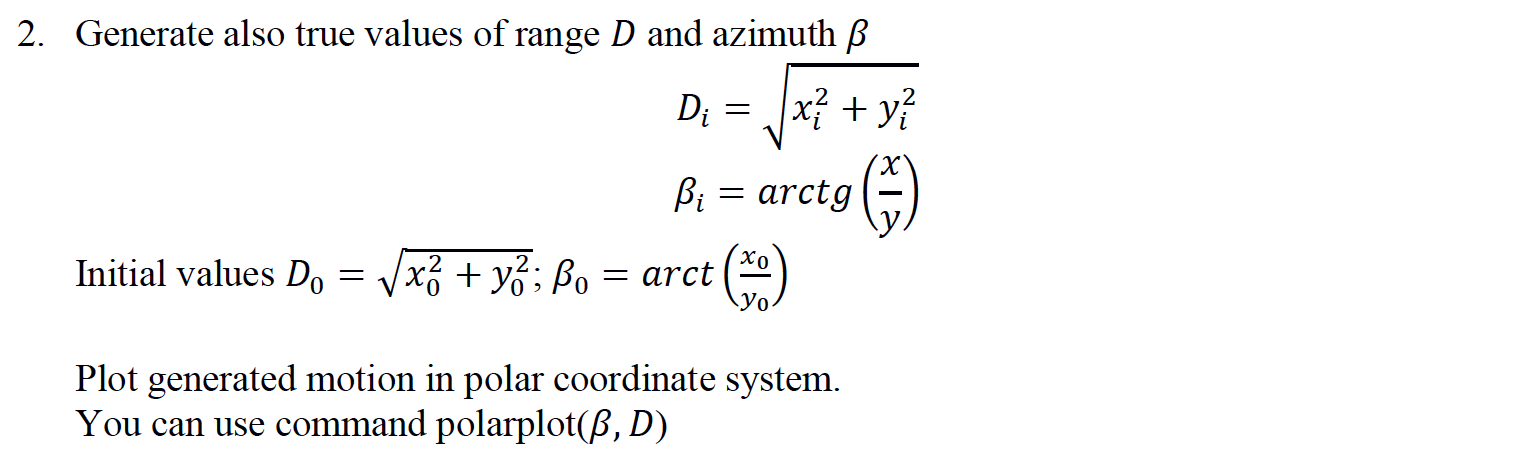

In [81]:
def generate_polar(X, Y, N = 26):
        
    D = np.zeros((N))
    beta = np.zeros((N))
    
    D[:] = np.sqrt(X[:]**2 + Y[:]**2)
    beta[:] = np.arctan2(X[:], Y[:])
    
    return D, beta

In [82]:
trD, trbeta = generate_polar(X, Y)

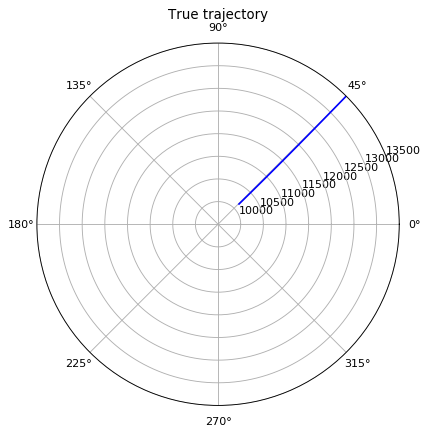

In [83]:
# Plot
plt.figure(figsize=(6, 6), dpi=80)
plt.polar(trbeta, trD, "b-")
plt.title('True trajectory')
plt.ylim((9500,13500))
plt.show()

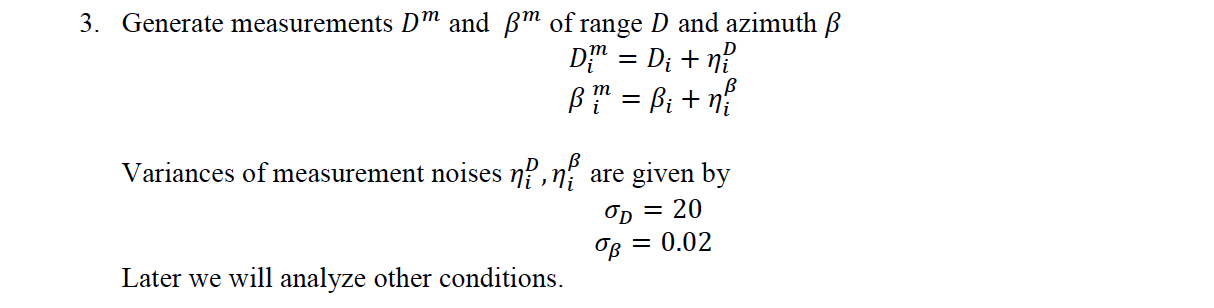

In [84]:
def measure(D, beta, sigma_D = 20, sigma_b = 0.02, mean = 0, N = 26):
    
    msr_D = np.zeros((D.shape))
    msr_b = np.zeros((beta.shape))
    
    noise_D = np.random.normal(loc = mean, scale = sigma_D, size = N)
    noise_b = np.random.normal(loc = mean, scale = sigma_b, size = N)
    
    msr_D = D[:] + noise_D
    msr_b = beta[:] + noise_b

    return msr_D, msr_b

In [85]:
msr_D, msr_b = measure(trD, trbeta, sigma_D = 20, sigma_b = 0.02, mean = 0, N = 26)

In [86]:
msr_b

array([0.78190823, 0.80871592, 0.79647347, 0.79274542, 0.77784782,
       0.81273569, 0.79548424, 0.76790646, 0.78329485, 0.77398936,
       0.78567444, 0.79823176, 0.78493895, 0.76767267, 0.76834733,
       0.76974095, 0.78885197, 0.77073288, 0.7690942 , 0.7831466 ,
       0.7670328 , 0.78298535, 0.78584154, 0.76288607, 0.80054411,
       0.77176065])

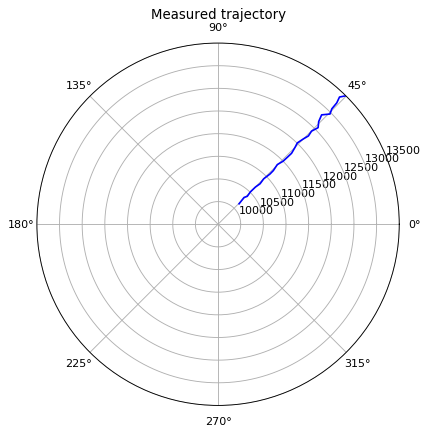

In [87]:
# Plot
plt.figure(figsize=(6, 6), dpi=80)
plt.polar(msr_b, msr_D, "b-")
plt.title('Measured trajectory')
plt.ylim((9500,13500))
plt.show()

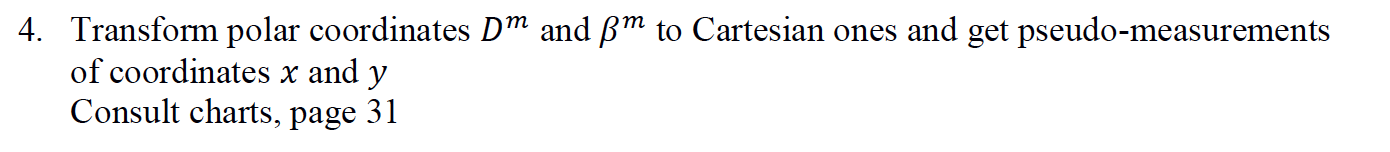

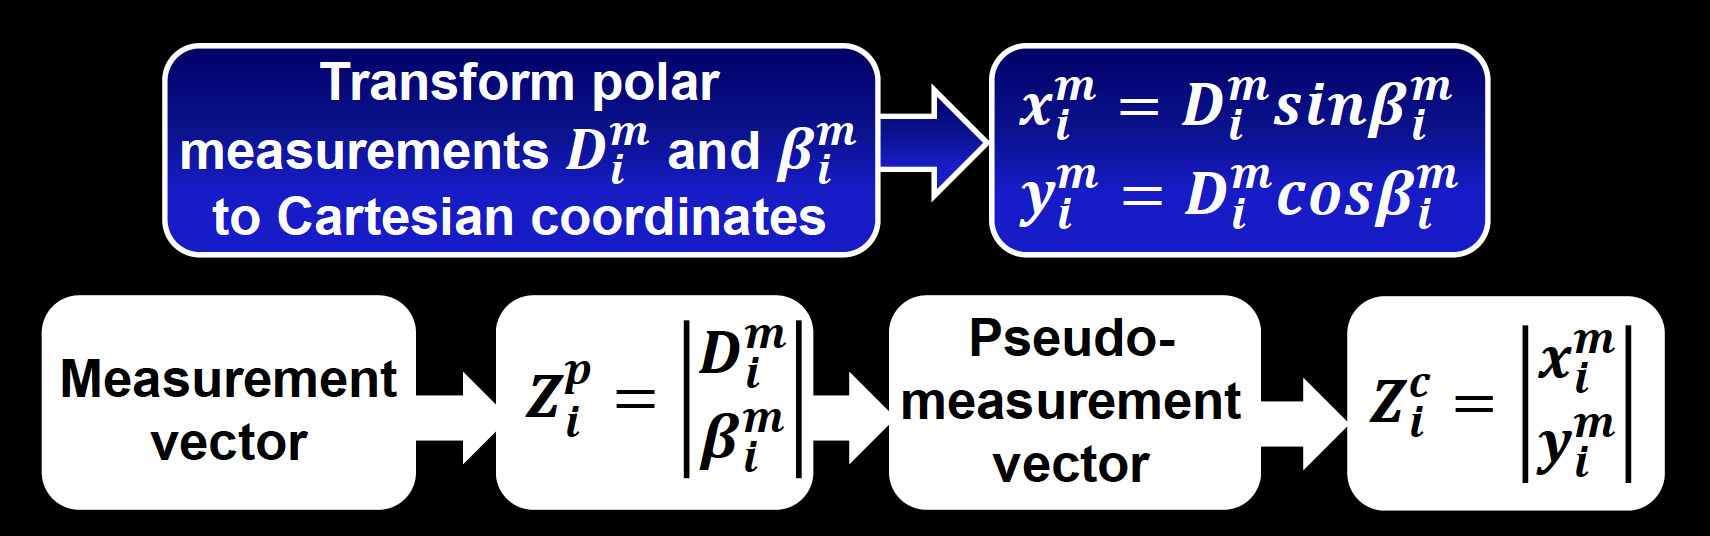

In [88]:
def transform_to_cartesian(msr_D, msr_b):
    
    msr_X = np.zeros((msr_D.shape))
    msr_Y = np.zeros((msr_b.shape))
    
    msr_X[:] = msr_D[:]*np.sin(msr_b[:])
    msr_Y[:] = msr_D[:]*np.cos(msr_b[:])
    
    return msr_X, msr_Y

In [89]:
msr_X, msr_Y = np.array(transform_to_cartesian(msr_D, msr_b))

In [90]:
data = [
    go.Scatter(
        x = X,
        y = Y,
        name='trajectory'
    ),
    go.Scatter(
        x = msr_X,
        y = msr_Y,
        mode = 'lines+markers',
        name='measurments'
    ),
]

layout= go.Layout(
    title= 'Cartesian coordinates',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

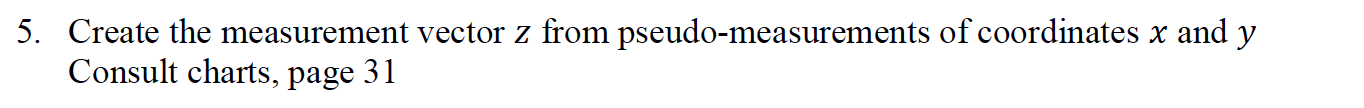

In [91]:
z = np.column_stack((msr_X,msr_Y))

In [92]:
z

array([[9536.87980299, 9603.67943441],
       [9681.2048322 , 9239.92653078],
       [9469.89112267, 9262.41663927],
       [9316.13691551, 9180.2368893 ],
       [9099.51421973, 9237.97117314],
       [9313.3289937 , 8817.5519938 ],
       [9051.76107801, 8870.98483056],
       [8731.06706601, 9041.97969882],
       [8758.26392325, 8795.1844006 ],
       [8589.46637125, 8787.72797217],
       [8602.98687358, 8598.23463147],
       [8597.98942738, 8380.08765097],
       [8412.33191533, 8420.06160139],
       [8163.2001562 , 8457.84734314],
       [8081.40071168, 8361.79811421],
       [8003.83800279, 8258.48136174],
       [8057.48306444, 8002.01643083],
       [7803.32686161, 8035.62629457],
       [7714.7768737 , 7970.53225661],
       [7706.04551891, 7740.82515914],
       [7487.10829558, 7767.29236466],
       [7521.64868618, 7558.03316189],
       [7436.81061227, 7430.21887252],
       [7180.69129562, 7511.49920659],
       [7409.97231818, 7188.84255501],
       [7076.239533  , 72

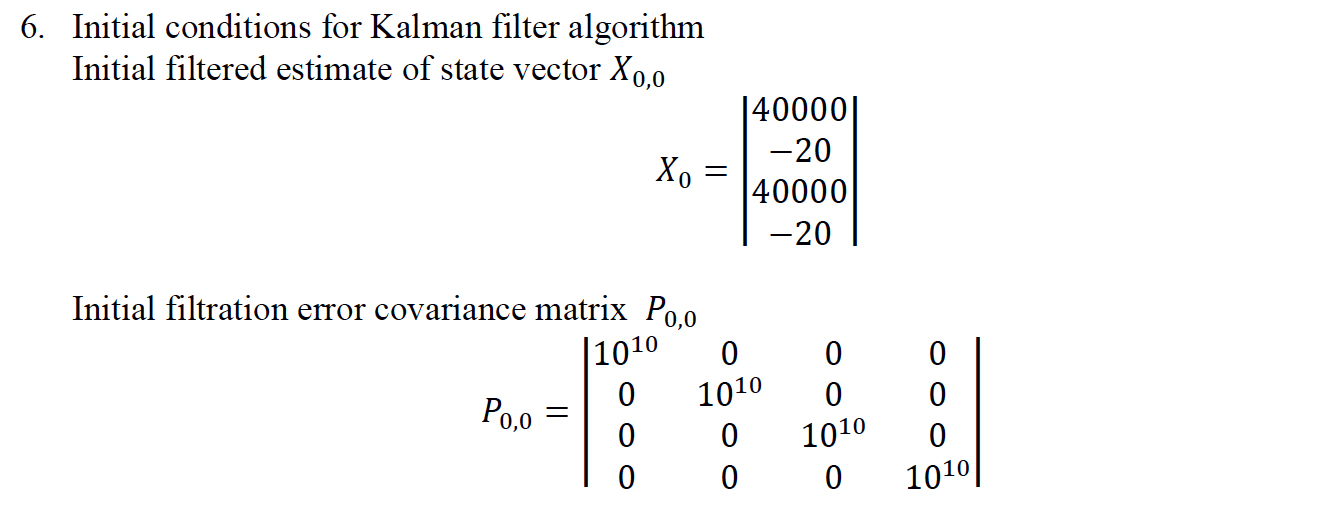

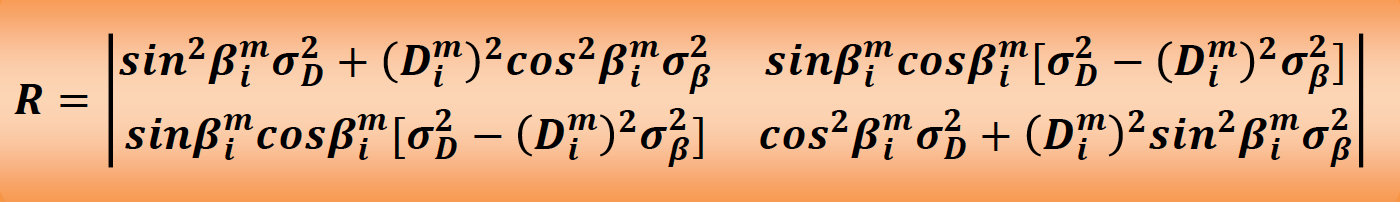

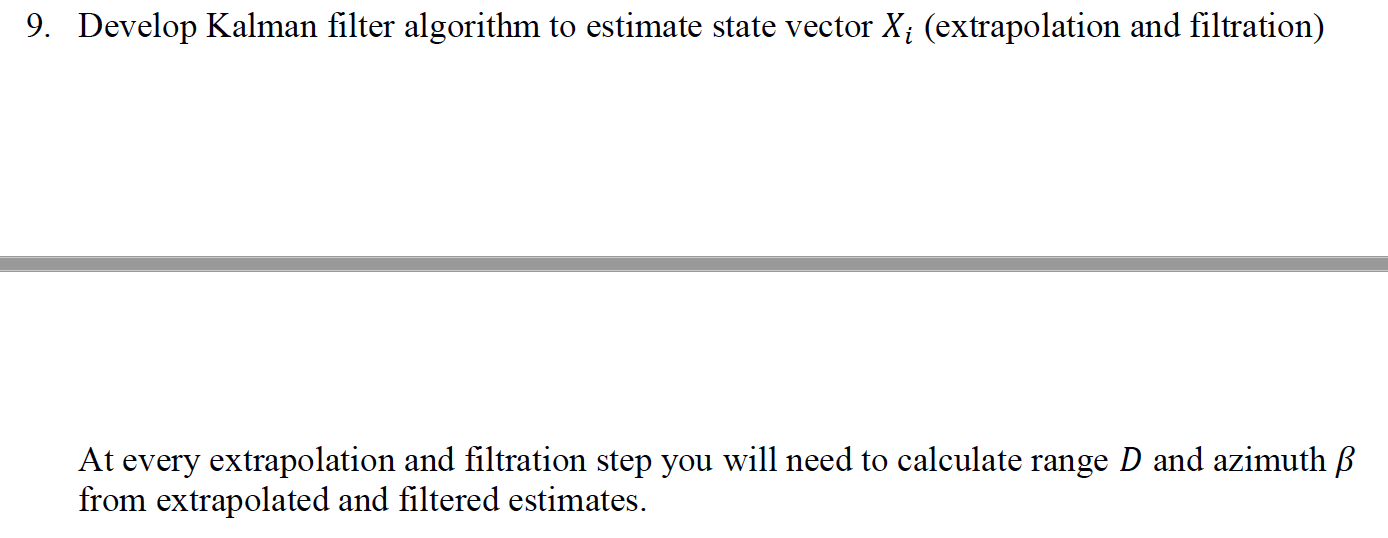

In [93]:
def create_R(sigma_D = 20, sigma_b = 0.02, msr_b = msr_b, msr_D = msr_D):
    
    r11 = (np.sin(msr_b[:]) * sigma_D)**2 + ((msr_D[:])**2)*(np.cos(msr_b[:])*sigma_b)**2
    r12 = np.sin(msr_b[:])*np.cos(msr_b[:])*(sigma_D**2 - ((msr_D[:])**2)*sigma_b**2)
    r21 = np.sin(msr_b[:])*np.cos(msr_b[:])*(sigma_D**2 - ((msr_D[:])**2)*sigma_b**2)
    r22 = (np.cos(msr_b[:]) * sigma_D)**2 + ((msr_D[:])**2)*(np.sin(msr_b[:])*sigma_b)**2

    # R = np.array([[r11, r12], [r21, r22]])
    R = np.column_stack((r11,r12, r21, r22)).reshape((26, 2, 2))

    return R

In [94]:
R = create_R(msr_b = msr_b, msr_D = msr_D)

In [95]:
def kalman(msr, R, S0, P0, T=2, sigma_D = 20, sigma_b = 0.02, q=0):
    
    size = len(msr)
            
    #G = np.array([(T**2)/2,T]).T
    #Q = G.dot(G.T)*0
    P = np.zeros((size, 4, 4))
    P_ = np.zeros((size, 4, 4))
    F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
    H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
    K = np.zeros((size, 4, 2))
    
    # allocate space for arrays
    X = np.zeros((len(msr), 4)) # predicted 
    X_ = np.zeros((len(msr), 4)) # filtered
    
    D = np.zeros((size,)) # predicted 
    D_ = np.zeros((size,)) # filtered
    beta = np.zeros((size,)) # predicted 
    beta_ = np.zeros((size,)) # filtered
    
    # intial guesses
    X_[0] = S0
    P_[0] = P0
    D[0] = np.sqrt(X[0][0]**2 + X[0][2]**2) # X and Y from state S0
    beta[0] = np.arctan2(X[0][0], X[0][2])  
    D_[0] = np.sqrt(X_[0][0]**2 + X_[0][2]**2) # X and Y from state S0
    beta_[0] = np.arctan2(X_[0][0], X_[0][2])    

    for k in range(1, size):
        
        # prediction
        X[k] = F.dot(X_[k-1])
        P[k] = F.dot(P_[k-1].dot(F.T))
        
        # polar predicted
        D[k] = np.sqrt(X[k][0]**2 + X[k][2]**2) # X and Y from state S0
        beta[k] = np.arctan2(X[k][0], X[k][2])

        # filtration
        K[k] = (P[k].dot(H.T)).dot(np.linalg.inv(H.dot(P[k].dot(H.T)) + R[k]))
        X_[k] = X[k] + K[k].dot(msr[k] - H.dot(X[k]))
        P_[k] = (np.eye(4) - np.dot(K[k], H)).dot(P[k])
        
        # polar filtered
        D_[k] = np.sqrt(X_[k][0]**2 + X_[k][2]**2) # X and Y from state S0
        beta_[k] = np.arctan2(X_[k][0], X_[k][2])

    return D, beta, D_, beta_, X_, K

In [96]:
D, beta, D_, beta_, X_, K = kalman(z, R, P0 = np.eye(4)*(10**10), S0 = np.array([40000, -20, 40000, -20]))

In [97]:
beta

array([ 0.        ,  0.78539816, -2.38270197,  0.78398099,  0.78400763,
        0.76733583,  0.79445587,  0.7943282 ,  0.77407016,  0.77389001,
        0.76937368,  0.7719865 ,  0.77826924,  0.77813488,  0.77252539,
        0.76837306,  0.76568689,  0.76918208,  0.76791085,  0.76585079,
        0.7674014 ,  0.76600696,  0.76765591,  0.76950526,  0.76697649,
        0.77419236])

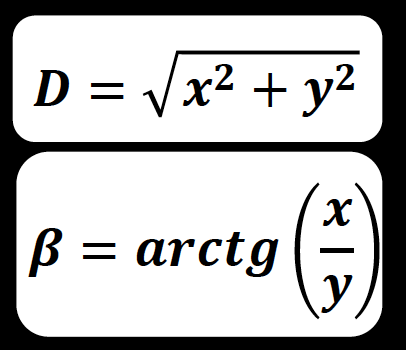

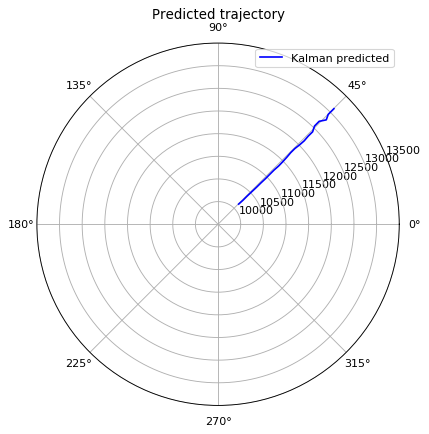

In [98]:
# Plot
plt.figure(figsize=(6, 6), dpi=80)
plt.polar(beta[3:], D[3:], "b-", label='Kalman predicted') # here we start from 4th value, because first three suck
plt.title('Predicted trajectory')
plt.ylim((9500,13500))
plt.legend()
plt.show()

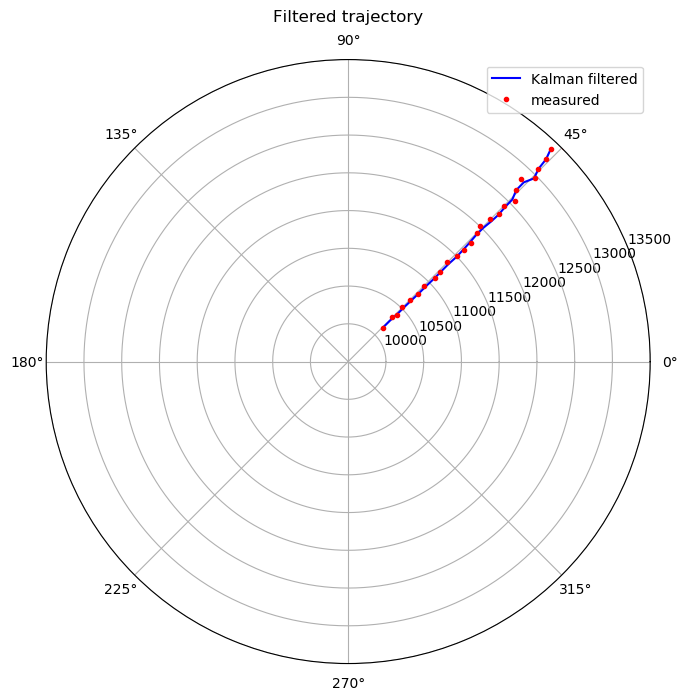

In [99]:
# Plot
plt.figure(figsize=(8, 8), dpi=100)
plt.polar(beta_[1:], D_[1:], "b-", label='Kalman filtered') # Kalman filtered, here we start from 2nd value
plt.polar(msr_b, msr_D, "r.", label='measured') # measured
plt.title('Filtered trajectory')
plt.ylim((9500,13500))
plt.legend()
plt.show()

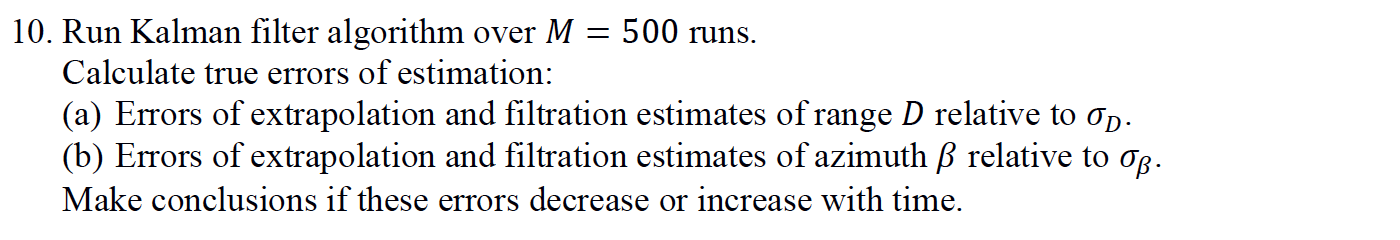

In [100]:
def experiment(M = 500, N = 26):
    
    # allocate space for arrays
    eD = np.zeros(N)
    eD_ = np.zeros(N)
    ebeta = np.zeros(N)
    ebeta_ = np.zeros(N)
    
    # for i in tqdm(range(M)):
    for i in range(M):

        X, Vx, Y, Vy = generate_trajectory(x0 = 13500/np.sqrt(2), y0 = 13500/np.sqrt(2), vx0 = -50, vy0 = -45, T = 2, N = 26)
        trD, trbeta = generate_polar(X, Y)
        msr_D, msr_b = measure(trD, trbeta, sigma_D = 20, sigma_b = 0.02, mean = 0, N = N)
        msr_X, msr_Y = np.array(transform_to_cartesian(msr_D, msr_b))
        z = np.column_stack((msr_X,msr_Y))
        R = create_R(msr_b = msr_b, msr_D = msr_D)
        D, beta, D_, beta_, X_, K = kalman(z, R, P0 = np.eye(4)*(10**10), S0 = np.array([40000, -20, 40000, -20]))
        
        eD_ += (D_ - trD)**2
        ebeta_ += (beta_ - trbeta)**2
        
        eD += (D - trD)**2
        ebeta += (beta - trbeta)**2
        
    eD_ = np.sqrt(eD_/(M-1))
    ebeta_ = np.sqrt(ebeta_/(M-1))
    
    eD = np.sqrt(eD/(M-1))
    ebeta = np.sqrt(ebeta/(M-1))
    
#         eD[i] = np.std(D) # std for each run
#         eD_[i] = np.std(D_)
#         ebeta[i] = np.std(beta)
#         ebeta_[i] = np.std(beta_)
        
    return eD, eD_, ebeta, ebeta_

In [101]:
eD, eD_, ebeta, ebeta_ = experiment()

In [102]:
ebeta

array([7.86184742e-01, 5.29577611e-04, 3.14436815e+00, 4.53009377e-02,
       3.14302510e-02, 2.48895918e-02, 2.26977612e-02, 1.87870232e-02,
       1.69611226e-02, 1.62960648e-02, 1.49657260e-02, 1.37736740e-02,
       1.33064519e-02, 1.26756913e-02, 1.21409305e-02, 1.18160418e-02,
       1.11690085e-02, 1.11694680e-02, 1.08223021e-02, 1.10148436e-02,
       1.04874718e-02, 1.01546203e-02, 9.89385608e-03, 9.71708987e-03,
       9.71164756e-03, 9.25157066e-03])

In [103]:
N = 26
sigma_b = np.full((N), 0.02)
sigma_D = np.full((N), 20)

In [104]:
data = [
    go.Scatter(
        y = eD[3:],
        name='std of prediction error D'
    ),
    go.Scatter(
        y = eD_[3:],
        name='std of filtration error'
    ),
    go.Scatter(
        y = sigma_D,
        name='sigma_D'
    ),
]

layout= go.Layout(
    title= '(a) Errors of extrapolation and filtration estimates of range 𝐷 relative to 𝜎𝐷',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'error',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [105]:
data = [

    go.Scatter(
        y = ebeta[3:],
        name='std of prediction error beta'
    ),
    go.Scatter(
        y = ebeta_[3:],
        name='std of filtration error beta'
    ),
    go.Scatter(
        y = sigma_b,
        name='sigma_b',
        #mode = 'lines+markers'
    ),

]

layout= go.Layout(
    title= '(b) Errors of extrapolation and filtration estimates of azimuth 𝛽 relative to 𝜎𝛽.',
    xaxis= dict(
        title= 'Step',
    ),
    yaxis=dict(
        title= 'error',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

Errors decrease with time!

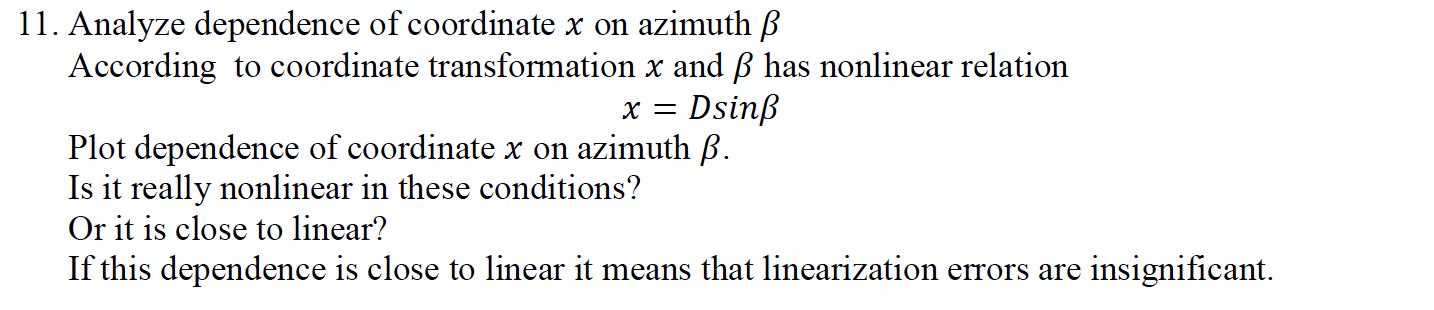

In [106]:
X, Vx, Y, Vy = generate_trajectory(x0 = 13500/np.sqrt(2), y0 = 13500/np.sqrt(2), vx0 = -50, vy0 = -45, T = 2, N = 26)
trD, trbeta = generate_polar(X, Y)
msr_D, msr_b = measure(trD, trbeta, sigma_D = 20, sigma_b = 0.02, mean = 0, N = N)
msr_X, msr_Y = np.array(transform_to_cartesian(msr_D, msr_b))
z = np.column_stack((msr_X,msr_Y))
R = create_R(msr_b = msr_b, msr_D = msr_D)
D, beta, D_, beta_, X_, K = kalman(z, R, P0 = np.eye(4)*(10**10), S0 = np.array([40000, -20, 40000, -20]))

In [107]:
R

array([[[ 35133.64014813, -36209.00356507],
        [-36209.00356507,  38147.03525412]],

       [[ 36823.47816491, -35590.17329967],
        [-35590.17329967,  35175.93297833]],

       [[ 36842.74797999, -34713.72834669],
        [-34713.72834669,  33466.74173939]],

       [[ 32941.41816591, -34012.27432638],
        [-34012.27432638,  35949.61246479]],

       [[ 33783.52818769, -33252.86611907],
        [-33252.86611907,  33522.71545764]],

       [[ 34436.32482039, -32694.11045937],
        [-32694.11045937,  31804.82600193]],

       [[ 33660.65039   , -32088.89000995],
        [-32088.89000995,  31358.41031359]],

       [[ 33032.69493993, -31225.86630318],
        [-31225.86630318,  30279.68747842]],

       [[ 32717.39246921, -30671.60213617],
        [-30671.60213617,  29509.62505703]],

       [[ 30981.72669307, -29900.7915399 ],
        [-29900.7915399 ,  29635.01814288]],

       [[ 29512.54667405, -29331.22077338],
        [-29331.22077338,  29951.53740719]],

       [[ 

## Вот тут не уверен, что правильно сделал

In [108]:
data = [

    go.Scatter(
        y = (D_*np.sin(beta_))[2:],
        name='std of prediction error beta'
    ),
]

layout= go.Layout(
    title= '(b) Errors of extrapolation and filtration estimates of azimuth 𝛽 relative to 𝜎𝛽.',
    xaxis= dict(
        title= 'steps',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In these conditions dependence it is close to linear. It means that linearization errors are insignificant.

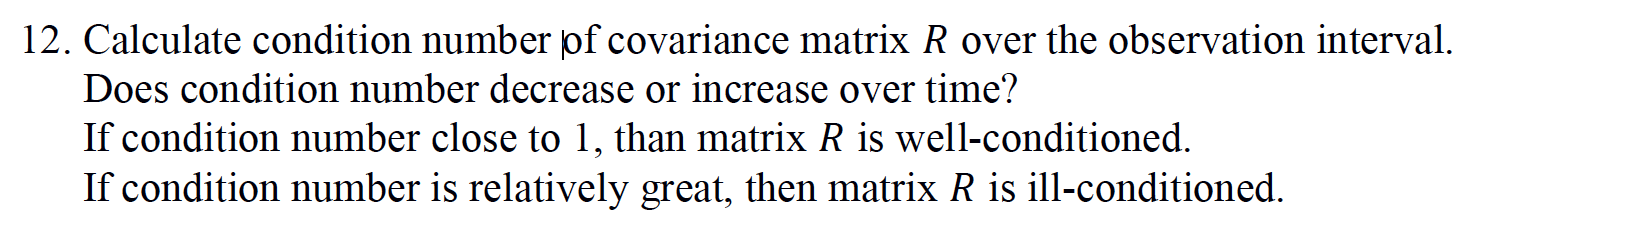

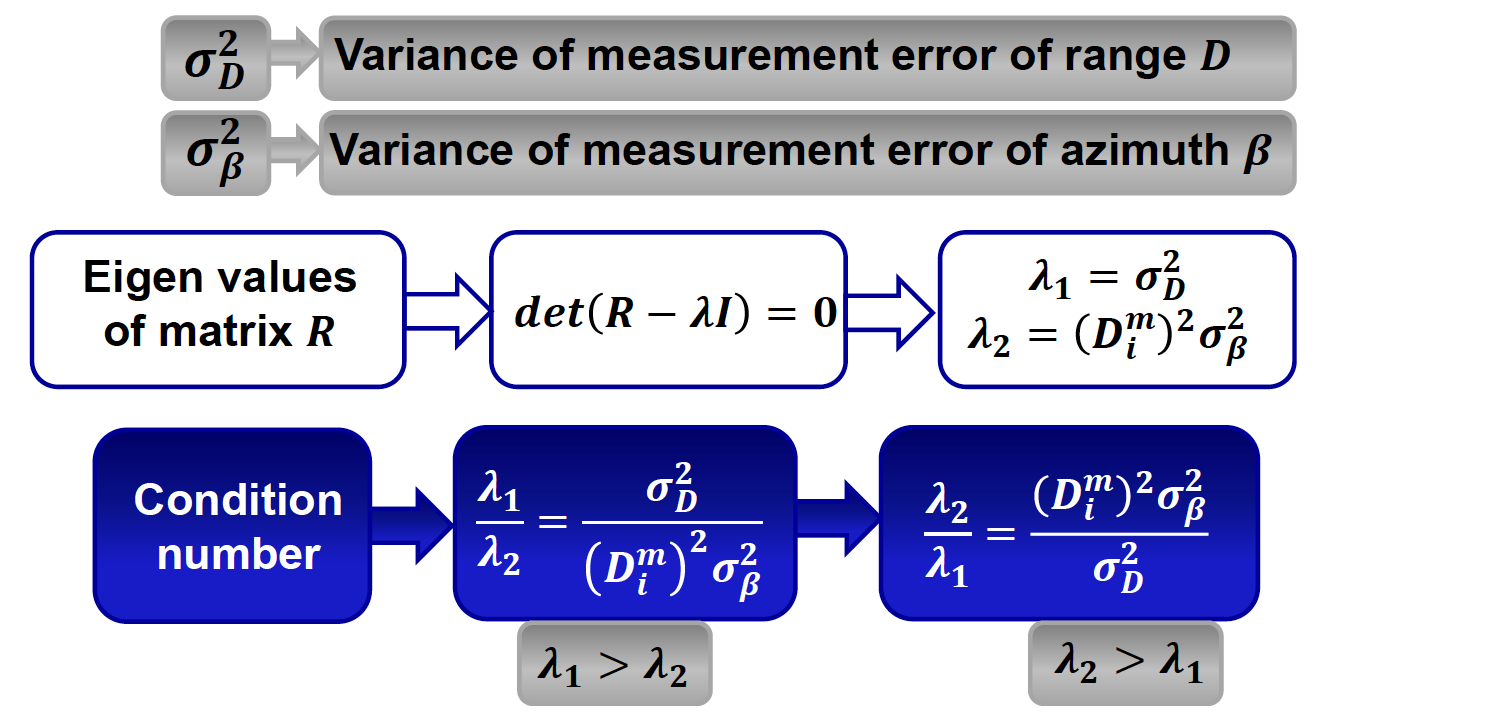

In [109]:
def cond_number(R):
    eigs, v = LA.eig(R) # get eigenvalues
    condition_number = np.zeros(len(eigs))
    eig1 = eigs[:, 0]
    eig2 = eigs[:, 1]
    for i in range(len(eigs)):
        condition_number[i] = eig1[i]/eig2[i] if eig1[i] > eig2[i] else eig2[i]/eig1[i]
    return condition_number

In [110]:
cond_number = cond_number(R)
cond_number

array([182.20168851, 178.99852786, 174.7737243 , 171.22757658,
       167.26560911, 164.60287706, 161.54765176, 157.28095605,
       154.56754382, 150.54186209, 147.6602102 , 145.23933773,
       141.91409897, 138.36385914, 134.30657327, 132.17936173,
       129.07346353, 125.0194834 , 123.17193019, 119.51347245,
       117.2479279 , 113.70886158, 112.09650363, 108.21000682,
       105.47876472, 103.05205086])

In [111]:
data = [
    go.Scatter(
        y = cond_number,
        name='condition_number'
    ),
]

layout= go.Layout(
    title= '(b) Errors of extrapolation and filtration estimates of azimuth 𝛽 relative to 𝜎𝛽.',
    xaxis= dict(
        title= 'steps',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

Condition number decreases over time.
If condition number close to 1, than matrix 𝑅 is well-conditioned. If condition number is relatively great, then matrix 𝑅 is ill-conditioned.
So, matrix 𝑅 is a bit ill-conditioned. Estimation accuracy is a little bit decreased and filter may diverge.

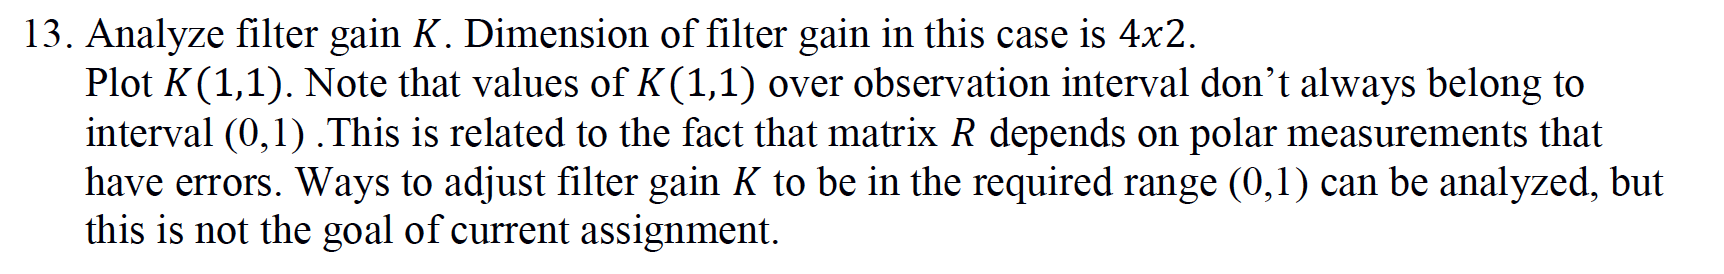

In [119]:
K[:, 0, 0]

array([ 0.        ,  0.99999926,  0.99999539,  1.31924191,  0.43553141,
        0.20485234,  0.43444039,  0.35607043,  0.28652662,  0.57645161,
        0.71440019,  0.31882003,  0.07327591,  0.20033368,  0.30413473,
       -0.12018788,  0.29382076, -0.0484242 ,  0.45417992,  0.36502626,
        0.36772321,  0.49404951,  0.1310504 , -0.02744547, -0.06781391,
        0.28538115])

In [120]:
data = [
    go.Scatter(
        y = K[:, 0, 0],
        name='Kalman gain K[0][0]'
    ),
]

layout= go.Layout(
    title= '(b) Errors of extrapolation and filtration estimates of azimuth 𝛽 relative to 𝜎𝛽.',
    xaxis= dict(
        title= 'steps',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

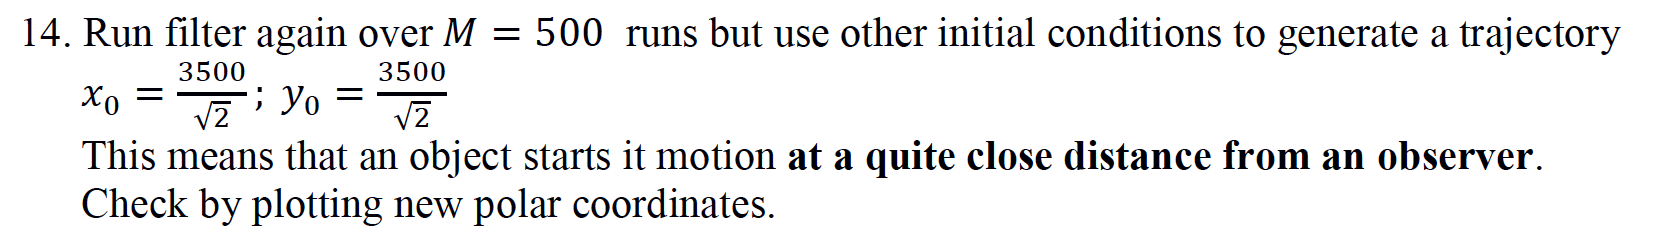